In [129]:
import numpy as np
import pandas as pd
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [245]:
dataset_dir = 'dataset/original_data'

datasets = os.listdir(dataset_dir)
datasets_df = pd.DataFrame({'filenames': datasets})

In [269]:
classes = ['concentrating', 'neutral']#, 'relaxed']
datasets_by_class = {'concentrating':[], 'neutral':[], 'relaxed':[]}
test_sets_by_class = {'concentrating':[], 'neutral':[], 'relaxed':[]}
window_size = 256 #samples


for class_name in classes:
    datasets = datasets_df[datasets_df['filenames'].str.contains(class_name)]

    for filename in datasets['filenames']:
        sub_df = pd.read_csv(f"{dataset_dir}/{filename}") 
        cutoff = int(sub_df.shape[0]*0.85)
        train_raw, test_raw = sub_df.iloc[:cutoff], sub_df.iloc[cutoff:]#train_test_split(sub_df, test_size=0.2, random_state=42, shuffle=False)
        # train_raw, test_raw = train_test_split(sub_df, test_size=0.2, shuffle=True)
        # train_raw = shuffle(train_raw)
        # test_raw = shuffle(test_raw)


        # NOTE: Split the data after reading, THEN perform sliding window
        
        # TRAINING DATA
        train_windows = []
        cur_window = []
        sample_count = 0

        row=0
        while row < train_raw.shape[0]:
            sample_count+=1
            cur_window.append(train_raw.iloc[row])

            if sample_count == window_size:
                train_windows.append(cur_window)
                cur_window = []
                sample_count = 0
                row-=window_size//2

            row+=1

        # TEST DATA
        test_windows = []
        cur_window = []
        sample_count = 0

        row=0
        while row < test_raw.shape[0]:
            sample_count+=1
            cur_window.append(test_raw.iloc[row])

            if sample_count == window_size:
                test_windows.append(cur_window)
                cur_window = []
                sample_count = 0
                row-=window_size//2

            row+=1

        # duplicates = 0
        # for u in train_windows:
        #     for v in test_windows:
        #         if np.array_equal(u,v):
        #             duplicates+=1

        # print(duplicates)


        datasets_by_class[class_name]+=train_windows
        test_sets_by_class[class_name]+=test_windows
        

In [270]:
concentrating_train_data = np.asarray(datasets_by_class['concentrating'], dtype='object')
neutral_train_data = np.asarray(datasets_by_class['neutral'], dtype='object')

concentrating_test_data = np.asarray(test_sets_by_class['concentrating'], dtype='object')
neutral_test_data = np.asarray(test_sets_by_class['neutral'], dtype='object')
# relaxed_data = np.asarray(datasets_by_class['relaxed'], dtype='object')

In [271]:
print("Training Data")
print(concentrating_train_data.shape)
print(neutral_train_data.shape)
# print(relaxed_data.shape)

print("Testing Data")
print(concentrating_test_data.shape)
print(neutral_test_data.shape)

Training Data
(705, 256, 6)
(609, 256, 6)
Testing Data
(114, 256, 6)
(97, 256, 6)


In [199]:
matrix = concentrating_train_data[0][:,1]
print(matrix.shape)

(256,)


In [135]:
# One sample
concentrating_train_data[0]

array([[1533222741.577, -6.348, 51.758, -24.414, 4.395, -9.277],
       [1533222741.58, -12.207, 55.664, -65.918, 3.906, -27.832],
       [1533222741.584, 1.953, 49.805, 61.523, 8.789, 11.719],
       ...,
       [1533222742.564, -15.137, 40.527, 70.801, -13.672, 5.859],
       [1533222742.568, 2.93, 42.969, 144.531, -12.207, 20.02],
       [1533222742.572, 6.836, 42.48, 120.605, -10.254, -21.973]],
      dtype=object)

In [273]:
X_train = concentrating_train_data[:, :, 1:5]  # Remove the first column
X_train = np.concatenate([X_train, neutral_train_data[:, :, 1:5]], axis=0)

X_test = concentrating_test_data[:, :, 1:5]  # Remove the first column
X_test = np.concatenate([X_test, neutral_test_data[:, :, 1:5]], axis=0)


y_train = np.array([0] * concentrating_train_data[:, :, 1:5].shape[0] + [1] * neutral_train_data[:, :, 1:5].shape[0])
y_test = np.array([0] * concentrating_test_data[:, :, 1:5].shape[0] + [1] * neutral_test_data[:, :, 1:5].shape[0])


In [274]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)


In [138]:
print(X_train.shape)
print(y_train.shape)

(1173, 256, 4)
(1173,)


In [264]:
def transform_set(scalar, data, fit=False):
    original_shape = data.shape 
    reshaped = data.reshape(-1, data.shape[-1]) 

    if fit:
        reshaped = scalar.fit_transform(reshaped)
    else:
        reshaped = scalar.transform(reshaped)
        
    reshaped = reshaped.reshape(original_shape)

    return reshaped

In [275]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler
X_scalar = MinMaxScaler()
X_train_scaled = transform_set(X_scalar, X_train, fit=True)
X_test_scaled = transform_set(X_scalar, X_test, fit=False)

In [192]:
X_train_scaled.shape

(1173, 256, 4)

In [276]:
import pickle

with open('models/X_scalar.pckl', 'wb') as file:
    # Pickle the data and write it to the file
    pickle.dump(X_scalar, file)


In [141]:
print("X data:", X_train.shape, X_test.shape)
print("y data:", y_train.shape, y_test.shape)

X data: (1173, 256, 4) (273, 256, 4)
y data: (1173,) (273,)


In [142]:
X_train_scaled.shape

(1173, 256, 4)

In [143]:
# X_train_joined = X_train_scaled.reshape((X_train_scaled.shape[0]*X_train_scaled.shape[1],4))

In [144]:
from tensorflow import keras
from tensorflow.keras import layers

In [277]:
# Define the input shape (256x4)
input_shape = (256, 4) 

# Build the CNN model
model = keras.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Two output neurons for two classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

/home/babybacon/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)              │ (None, 254, 32)        │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 127, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 125, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 60, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │       983,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,625 (3.87 MB)

 Trainable params: 1,014,625 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [278]:
model.fit(X_train_scaled, y_train, epochs=20, validation_data=(X_test_scaled, y_test))

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5096 - loss: 0.7048 - val_accuracy: 0.5450 - val_loss: 0.6777
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6264 - loss: 0.6226 - val_accuracy: 0.8009 - val_loss: 0.5392
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7750 - loss: 0.4809 - val_accuracy: 0.8057 - val_loss: 0.5645
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8190 - loss: 0.4520 - val_accuracy: 0.7488 - val_loss: 0.5732
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8178 - loss: 0.4046 - val_accuracy: 0.7630 - val_loss: 0.6724
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8151 - loss: 0.4053 - val_accuracy: 0.6682 - val_loss: 0.8436
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8299 - loss: 0.3760 - val_accuracy: 0.8009 - val_loss: 0.6895
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8387 - loss: 0.3823 - val_accuracy: 0.7678 - val_loss

In [193]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(1173, 256, 4)
(273, 256, 4)


In [279]:
model.save('models/m1.keras')

In [256]:
preds = model.predict(X_test_scaled)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [257]:
score = 0

for i in range(preds.shape[0]):
    is_equal = (np.round(preds[i]) == np.round(y_test[i]))
    if is_equal:
        score+=1

print(f"{score}/{preds.shape[0]}")

236/289


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [29]:
X_test_scaled[0].shape

(256, 4)

In [69]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([155, 134]))

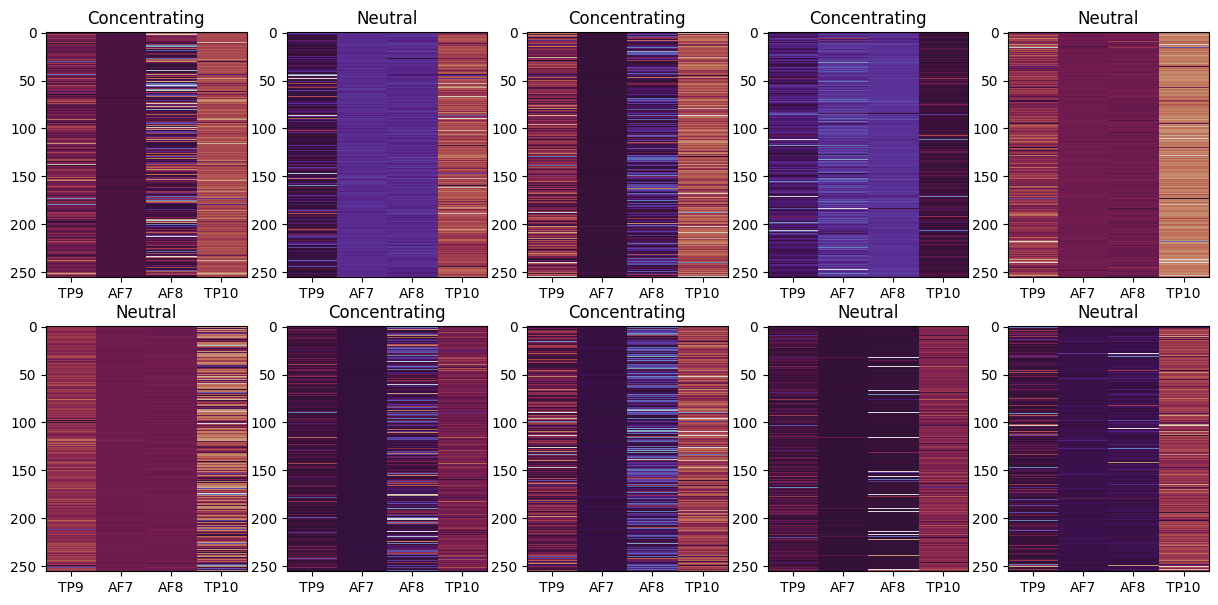

In [258]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming X_test_scaled and y_test are already defined, and each image is 2D
fig, axes = plt.subplots(2, 5, figsize=(15, 7))  # Create a 2x5 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate through it


positives = 0
negatives = 0

i = 20
while positives<5 or negatives<5:

    if (y_train[i] == 1 and positives<5) or (y_train[i] == 0 and negatives<5):
        ax = axes[positives+negatives]  # Select the subplot for the current image
        ax.imshow(X_train_scaled[i], cmap='twilight', interpolation='nearest', aspect='auto')
        ax.set_title(
            'Concentrating' if y_train[i]==0 else 'Neutral'
            )  # Set title with the label
        # ax.axis('off')  # Hide axis for a cleaner look
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels(['TP9','AF7','AF8','TP10'])

        positives+=int(y_train[i]==1)
        negatives+=int(y_train[i]==0)

    i+=1

# Show the plot
# plt.savefig('classes_shuffled_data.png')
plt.show()

In [181]:
def plot_sample(sample):
    variables = ['TP9','AF7','AF8','TP10']
    # Number of samples
    num_samples = sample.shape[0]

    # Create a figure with 5 subplots (1 column and 5 rows)
    fig, axes = plt.subplots(4, 1, figsize=(10, 15))

    # Plot each of the 5 variables in separate subplots
    for i in range(sample.shape[1]):
        axes[i].plot(range(num_samples), sample[:, i], label=f'Variable {i+1}')
        axes[i].set_title(f'{variables[i]}')
        axes[i].set_ylabel('Value')
        axes[i].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plot
    plt.show()

1


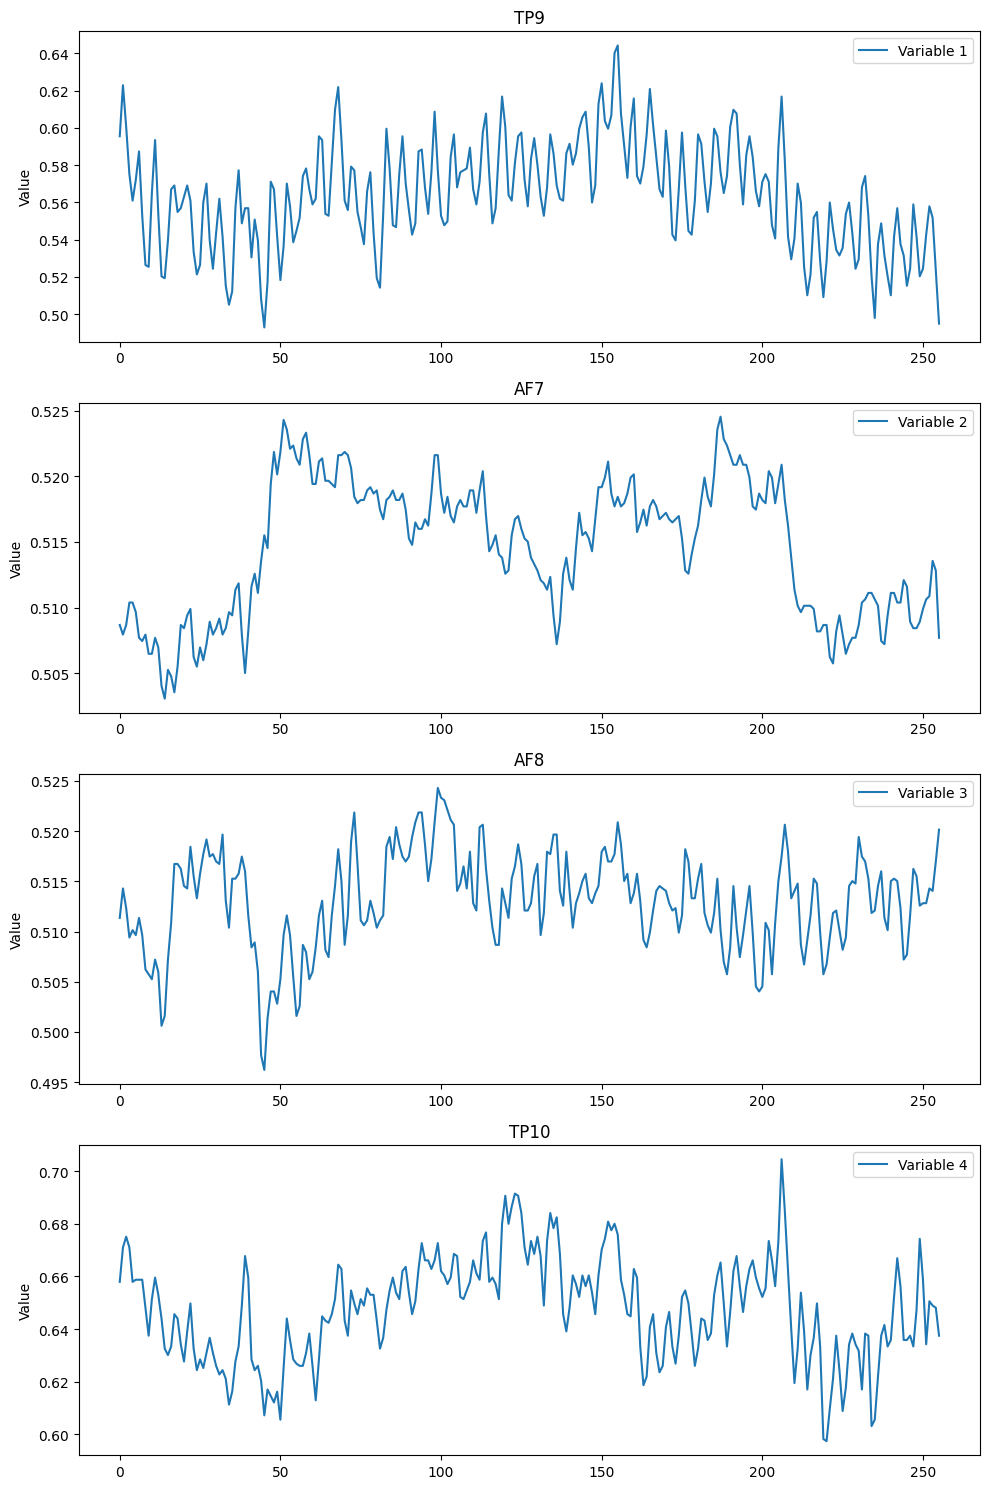

In [186]:
a = 9
print(y_train[a])
plot_sample(X_train_scaled[a])

In [ ]:
eeg_data = X_train_scaled[1]  # Simulated EEG data

eeg_data = eeg_data.reshape(4,256)

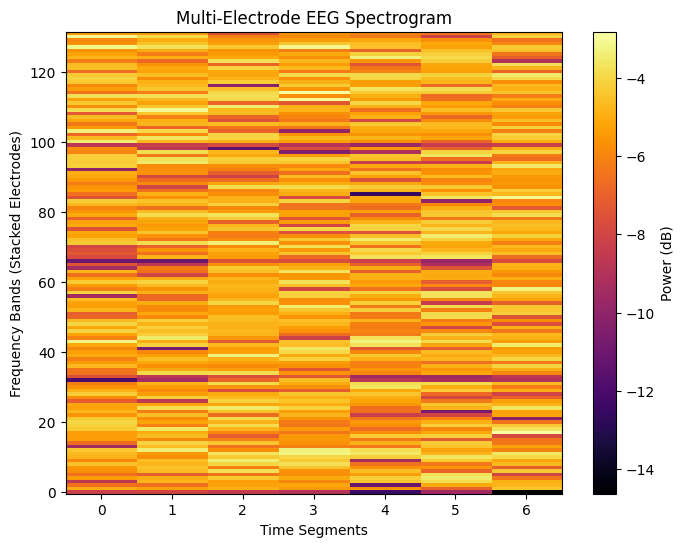

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Example EEG data (4 electrodes, 256 samples per second)
fs = 256  # Sampling frequency in Hz
time = np.linspace(0, 1, fs)  # 1 second of data
eeg_data = np.random.randn(4, fs)  # Simulated EEG data (replace with real EEG)

# Initialize a list to store spectrograms
spectrograms = []

# Compute the spectrogram for each electrode
for i in range(eeg_data.shape[0]):
    f, t, Sxx = spectrogram(eeg_data[i, :], fs=fs, nperseg=64, noverlap=32)
    spectrograms.append(np.log(Sxx + 1e-8))  # Log transform for better visualization

# Stack spectrograms vertically to form a single image
spectrogram_image = np.vstack(spectrograms)

# Plot the combined spectrogram
plt.figure(figsize=(8, 6))
plt.imshow(spectrogram_image, aspect='auto', cmap='inferno', origin='lower')
plt.title('Multi-Electrode EEG Spectrogram')
plt.xlabel('Time Segments')
plt.ylabel('Frequency Bands (Stacked Electrodes)')
plt.colorbar(label='Power (dB)')
plt.show()

In [ ]:
spectrogram_image.shape

(132, 7)